# Tarea Semanal 4: Simulación de un ADC (cuantización) parte 2/2
## Magdalena Noé
Descripcion

#### Librerias:

In [21]:
import numpy as np
import matplotlib.pyplot as plt #Para la visualizacion de tt y xx.
from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()
import scipy.signal as sig

## Generacion de la señal discreta sR con ruido

Señal seno

In [32]:
fs = 1000 # [Hz]
N = fs    # cantidad de muestras
fo = fs/N # [Hz]
Vmax = 1 #np.sqrt(2) #[Volts]

def mi_funcion_sen(vmax=1,dc=0,ff=1,ph=0,nn=1000,fs=1000):
    t = np.arange(nn) / fs
    sin = vmax * np.sin(t*2*np.pi*ff + ph) + dc
    return t, sin

tt,analog_sig = mi_funcion_sen(fs=fs, nn=N, ff=fo, vmax=Vmax)

df = fs/N # resolución espectral

Contaminacion de la señal y cuantizacion del resultado

In [48]:
Vf = 2 #[Volts] 
B = 4 # Bits
q = Vf/2**(B-1)

kn = 1
Pq = q**2/12
Pn = kn * Pq # Pot ruido [Watts]
n = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N) # Ruido

sr = analog_sig + n
srq = np.round(sr / q) * q # Cuantizacion
nq = srq - sr # Error de cuantizacion

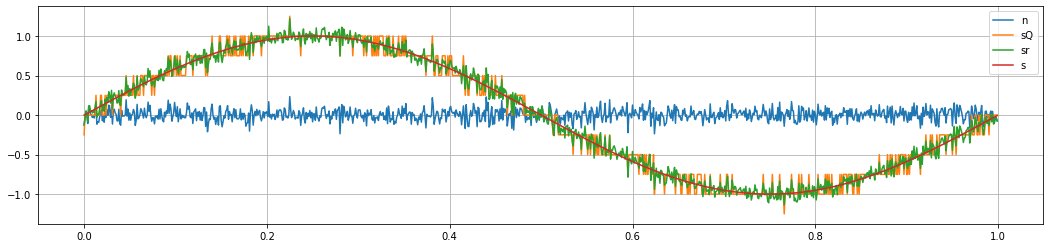

In [54]:
def graficar_funcion(abs,ord,leg="",label_y="",label_x="",titulo="",xlim=0,show=1):
    for k in np.arange(len(ord)):
        plt.plot(abs, ord[k], label=leg[k])
    if(xlim):
        plt.xlim(0, xlim)
    else:
        plt.axis('tight')

    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(titulo)
    plt.grid()
    plt.legend()
    if(show): #Para manejar subplots por fuera de la funcion
        plt.show()
    return

plt.figure(figsize=(18, 4))
graficar_funcion(tt,[n,srq,sr,analog_sig],["n","sQ","sr","s"])

## Oversampling (OS)

In [64]:
oversamp = 4
N_os = N * oversamp
fs_os = fs * oversamp
ts_os = 1/fs_os

tt_os = np.arange(0, N_os) * ts_os
s_os = Vmax * np.sin(tt_os*2*np.pi*fo)

## FFT

In [65]:
ff = np.fft.fftfreq(N, d=1/fs)
ff_os = np.fft.fftfreq(N_os, d=1/fs_os)

fft_s = fft(analog_sig) / N               # Seno
ft_Srq = fft(srq) / N             # Seno con ruido cuantizado
ft_SR = fft(sr) / N             # Seno con ruido
ft_Nq = fft(nq) / N             # Error de cuantizacion
ft_As = fft(analog_sig) / N_os # Seno puro

nNn = np.random.normal(0, np.sqrt(Pn), size=N_os) # Ruido oversampling
ft_Nn = fft(nNn) / N_os
nNn_mean = np.mean(np.abs(ft_Nn)**2)
Nnq_mean = np.mean(np.abs(ft_Nq)**2)

bfrec = (ff >= 0) & (ff <= fs/2)
ff_valid = ff[bfrec]

bfrec_os = (ff_os >= 0) & (ff_os <= fs/2)
ff_os_valid = ff_os[bfrec_os]

## Graficos

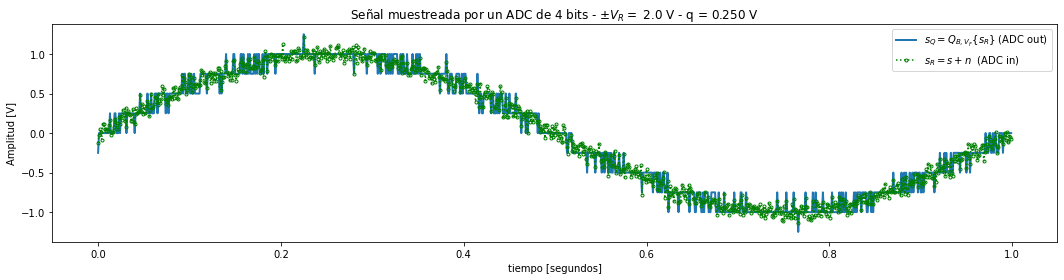

Text(0.5, 1.0, 'Ruido de cuantización para 4 bits - $\\pm V_R= $ 2.0 V - q = 0.250 V')

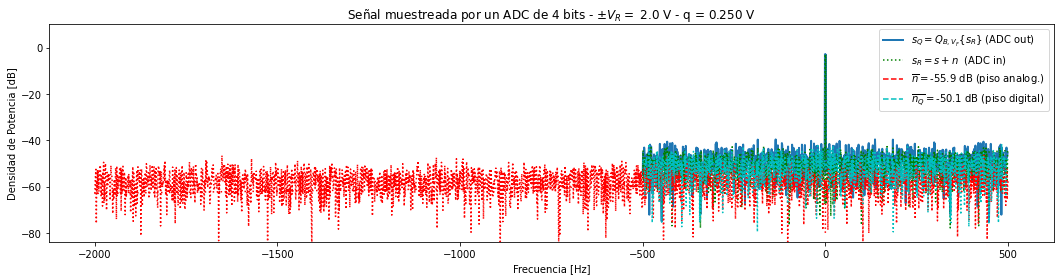

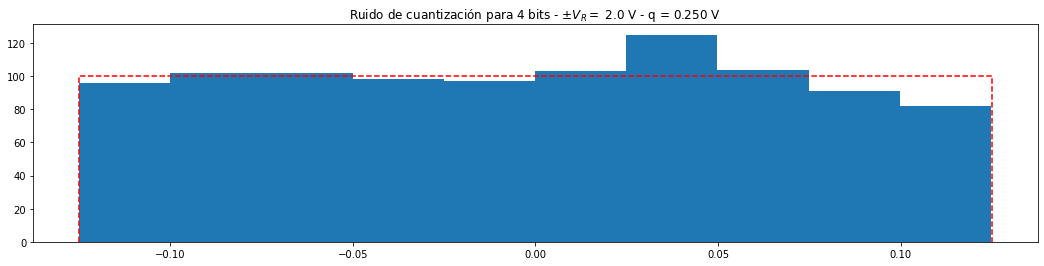

In [70]:
plt.close('all')
 
plt.figure(1, figsize=(18, 4))
plt.plot(tt, srq, lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green',marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$ s_R = s + n $  (ADC in)')

#plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$ s $ (analog)')
 
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()
 
 
plt.figure(2, figsize=(18, 4))
bfrec = ff <= fs/2
 
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
 
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)' )

#plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$ s $ (analog)' )

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $  (ADC in)' )
plt.plot( ff_os[ff_os <= fs/2], 10* np.log10(2*np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()
# suponiendo valores negativos de potencia ruido en dB
plt.ylim((1.5*np.min(10* np.log10(2* np.array([Nnq_mean, nNn_mean]))),10))
 
 
plt.figure(3, figsize=(18, 4))
bins = 10
plt.hist(nq, bins=bins)
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))